# Imports

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import numpy as np
from tqdm import tqdm
import dask.dataframe as dd

from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.recurrent import LSTM
from keras.layers import Dense, Conv1D, MaxPool2D, Flatten, Dropout
from keras.callbacks import EarlyStopping, TensorBoard
from keras.optimizers import Adam, SGD, Nadam
from time import time
from livelossplot import PlotLossesKeras
from keras.layers.advanced_activations import LeakyReLU, PReLU
import tensorflow as tf
from keras.utils.training_utils import multi_gpu_model
from tensorflow.python.client import device_lib
from sklearn.preprocessing import StandardScaler

from keijzer import setup_multi_gpus, create_corr_matrix, reduce_memory, resample_df

mpl.style.use('default')
#%matplotlib notebook
%matplotlib inline
sns.set()

In [82]:
# Setup multi GPU usage
num_gpu = setup_multi_gpus()

Amount of GPUs available: 4


# Load data

In [83]:
df = pd.read_csv('//datc//opschaler//combined_gas_smart_weather_dfs//processed/all_dwellings_combined_hour.csv', delimiter='\t', parse_dates=['datetime'])
df = df.set_index(['datetime'])
df = df.dropna()

# Get an hour dataframe
df = resample_df(df, 'D', combine_all_dwellings=True)

#df['year'] = df.index.year
#df['month'] = df.index.month
#df['day'] = df.index.day
#df['hour'] = df.index.hour #create column containing the hour
#df['dayofweek'] = df.index.dayofweek
#df['season'] = (df.index.month%12 + 3)//3 # Calculates the season (categorical)

In [84]:
df.head()

,ePower,ePowerReturn,DD,DR,FF,FX,N,P,Q,RG,SQ,T,T10,TD,U,VV,WW,gasPower,dwelling
datetime,,,,,,,,,,,,,,,,,,,
2017-02-22,185.730438,0.0,243.831944,444.333333,8.236250,12.023750,7.388889,1005.554169,30.708333,1.112500,0.000000,9.236111,8.973611,8.283333,93.319444,9911.805583,54.069444,0.256246,All dwellings
2017-02-23,173.374907,0.0,239.148194,265.916667,11.608438,17.165569,7.612500,995.103327,24.312500,0.461319,0.149737,8.590000,8.163889,6.441597,86.511805,12887.305430,41.759722,0.485713,All dwellings
2017-02-24,246.992340,0.0,278.093543,45.766667,5.032826,7.413604,4.665972,1011.765422,107.562499,0.054306,2.962413,4.746250,3.968194,2.241736,83.740972,28850.902303,13.997222,0.276830,All dwellings
2017-02-25,150.144606,0.0,202.265418,14.750000,6.502271,9.496715,6.166667,1016.465144,49.312501,0.002083,0.361316,5.606806,4.653194,2.398264,79.870832,28918.541423,9.211111,0.017166,All dwellings
2017-02-26,679.171475,0.0,208.350207,82.633334,7.540049,11.129507,7.694444,1008.878202,24.770834,0.098611,0.039483,8.688750,8.264306,6.636181,86.559028,20726.805461,17.117361,0.503001,All dwellings


# Select data to use

Saving heatmap
Len of data:  278


/opt/jupyterhub/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


<Figure size 576x396 with 0 Axes>

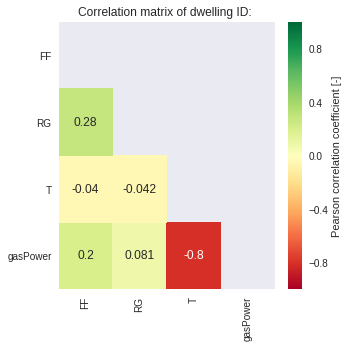

In [85]:
data = df
#data = data.drop(['eMeter', 'eMeterReturn', 'eMeterLow', 'eMeterLowReturn', 'gasMeter', 'dwelling'], axis=1) # Not needed
data = data.drop(['dwelling'], axis=1) # Not needed
data = data.drop(['WW', 'VV', 'P', 'DR', 'SQ', 'TD', 'T10', 'FX'], axis=1) # Drop weather columns which contain correlated information, keep only one type
#sns.heatmap(data.corr(), annot=True)

data = data.drop(['ePower', 'ePowerReturn'], axis=1) # Drop if want to predict gasPower

# Drop columns with that have a |corr| > 0.1 with T
data = data.drop(['U', 'N', 'Q', 'DD'], axis=1)


#data = data[data['T'] < 0] #filter data based on condition
#data = data.reset_index()
magnitude = 1
data['gasPower'] = data['gasPower']*10**magnitude
data = data.dropna()

fig = create_corr_matrix(data, '', True, size=(5,5))

print('Len of data: ', len(data))

(array([736389., 736420., 736450., 736481., 736511., 736542., 736573.,
        736603., 736634., 736664.]), <a list of 10 Text xticklabel objects>)

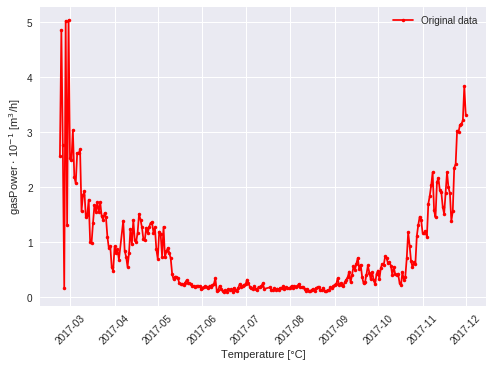

In [86]:
plt.plot(data.index, data['gasPower'], '.-', color='r', label='Original data')
plt.xlabel('Temperature [°C]')
plt.ylabel(r'gasPower $\cdot$ 10$^{-%s}$ [m$^3$/h]' % magnitude)
plt.legend()
plt.xticks(rotation=45)

# Preprocessing

In [87]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 278 entries, 2017-02-22 to 2017-12-01
Data columns (total 4 columns):
FF          278 non-null float64
RG          278 non-null float64
T           278 non-null float64
gasPower    278 non-null float64
dtypes: float64(4)
memory usage: 10.9 KB


In [89]:
data.values.shape

(278, 4)

In [118]:
# Create some artificial data to easier see what the reshaping is actually doing

a = np.arange(0, 50, 1).reshape(50,1) # 1 to 50 in steps of 1
b = np.arange(2, 102, 2).reshape(50,1) # 2 to 102 in stepf of 2
c = np.arange(0.5, 25.5, 0.5).reshape(50,1) # 0.5 to 25.5 in steps of 0.5

data = np.concatenate([a,b,c], axis=1)
data[:5] # data is now in the same format as a pandas dataframe with 3 columns

array([[ 0. ,  2. ,  0.5],
       [ 1. ,  4. ,  1. ],
       [ 2. ,  6. ,  1.5],
       [ 3. ,  8. ,  2. ],
       [ 4. , 10. ,  2.5]])

In [128]:
# Make it a dataframe, because the original data is still a dataframe at this point
data = pd.DataFrame(data, columns=['a', 'b', 'c'])
data.head()

,a,b,c
0,0.0,2.0,0.5
1,1.0,4.0,1.0
2,2.0,6.0,1.5
3,3.0,8.0,2.0
4,4.0,10.0,2.5


## Define train size and target column number

In [129]:
train_size = 0.1
target_column = 2

split_idx = int(data.shape[0]*train_size) # index nummer to split at
split_idx

5

In [163]:
data.values.shape # 278 rows by 4 columns

(50, 3)

## Split data to X/y train/test

In [131]:
# ...train
X_train = data.values[:split_idx, :target_column]
y_train = data.values[:split_idx, target_column]

# ...test
X_test = data.values[split_idx:-1, :target_column]
y_test = data.values[split_idx:-1, target_column]

In [228]:
X_train

array([[ 0.,  2.],
       [ 1.,  4.],
       [ 2.,  6.],
       [ 3.,  8.],
       [ 4., 10.]])

In [137]:
X_train.shape # 27 rows by 3 columns

(5, 2)

In [138]:
y_train

array([0.5, 1. , 1.5, 2. , 2.5])

In [133]:
y_train.shape # 27 rows

(5,)

In [134]:
y_train

array([0.5, 1. , 1.5, 2. , 2.5])

## Scale X train/test

In [34]:
# Scale the data
#scalerX = StandardScaler(with_mean=True, with_std=True).fit(X_train)
#X_train = scalerX.transform(X_train)
#X_test = scalerX.transform(X_test)

## Get the data in LSTM format
format = (samples, timesteps, feautures)  
or in other words (samples, lookback, feautures)

In [217]:
# Define variables
look_back = 2 # look back 5 steps
n_features = 2 # using 3 feautures
output_dim = 1 # to predict 1 y value

In [218]:
samples = len(X_train) # total amount of samples
samples

5

In [219]:
samples_train = X_train.shape[0] - look_back 
samples_train

3

## Reshape train data
### Visual explanation

Let $A$ be a (5 $\times$ 3) matrix, so 5 rows by 3 columns.  
There are 2 feautures $X$, column 1 is feature $X_1$ and column 2 is the second feature $X_2$.  
Column 3 is the target $y$.  
  
This matrix is obtained by `df.values`.  
To prepare this for usage with LSTM it has to be split in $X$ and $y$.  
Where $X$ is in the shape $(samples, timesteps, features)$.  
In which timesteps can be interpreted as 'lookback', i.e. the amount of timesteps being looked back to predict the $y$ value at said point.  

For example:

$A = \begin{bmatrix}
0 & 2 & 0.5 \\ 
1 & 4 & 1.0 \\ 
2 & 6 & 1.5 \\ 
3 & 8 & 2.0 \\ 
4 & 10 & 2.5 
\end{bmatrix}$

Or more precise, in numpy this would be in the form:

$ A = \begin{bmatrix}
\begin{bmatrix} 0 & 2 & 0.5 \end{bmatrix} \\ 
\begin{bmatrix} 1 & 4 & 1.0 \end{bmatrix} \\ 
\begin{bmatrix} 2 & 6 & 1.5 \end{bmatrix} \\ 
\begin{bmatrix} 3 & 8 & 2.0 \end{bmatrix} \\ 
\begin{bmatrix} 4 & 10 & 2.5 \end{bmatrix}
\end{bmatrix}$

Next step is to split $A$ into the feature matrix $X$ and the target matrix $y$.

$ X = \begin{bmatrix}
\begin{bmatrix} 0 & 2 \end{bmatrix} \\ 
\begin{bmatrix} 1 & 4 \end{bmatrix} \\ 
\begin{bmatrix} 2 & 6 \end{bmatrix} \\ 
\begin{bmatrix} 3 & 8 \end{bmatrix} \\ 
\begin{bmatrix} 4 & 10 \end{bmatrix}
\end{bmatrix}$ $ \ \ \ \ \ \ \ \ \ \    y = \begin{bmatrix} 0.5 & 1.0 & 1.5 & 2.0 & 2.5 \end{bmatrix}$

Now say that timesteps (or lookback) equals 2.  
So the idea is to use the two previous $X$ values to predict the current $y$ value.   

Then $\begin{bmatrix}
\begin{bmatrix} 0 & 2  \end{bmatrix} \\ 
\begin{bmatrix} 1 & 4 \end{bmatrix}
\end{bmatrix}$ will be used to predict $\begin{bmatrix}
\begin{bmatrix} 1.5 \end{bmatrix}
\end{bmatrix}$.  

Note that $\begin{bmatrix}
\begin{bmatrix} 0.5  \end{bmatrix} \\ 
\begin{bmatrix} 1.0 \end{bmatrix}
\end{bmatrix}$ cannot be predicted because the previous two $X$ values for them are not available.

To get this done $X$ has to be reshaped to size $(samples, timesteps, features)$.

$ X = \begin{bmatrix} \begin{bmatrix}
\begin{bmatrix} 0 & 2 \end{bmatrix} \\
\begin{bmatrix} 1 & 4 \end{bmatrix}
\end{bmatrix} \\ 
\begin{bmatrix}
\begin{bmatrix} 1 & 4 \end{bmatrix} \\
\begin{bmatrix} 2 & 6 \end{bmatrix}
\end{bmatrix} \\
\begin{bmatrix}
\begin{bmatrix} 2 & 6 \end{bmatrix} \\
\begin{bmatrix} 3 & 8 \end{bmatrix}
\end{bmatrix} \end{bmatrix}  \ \ \ \ \ $ to predict  $ \ \ \ \ \     y = \begin{bmatrix} 1.5 & 2.0 & 2.5 \end{bmatrix}$

Finally, $X$ and $y$ can be used as input for a LSTM network.

### The code

In [237]:
# Define zeros array with the target shape
X_train_reshaped = np.zeros((samples_train, look_back, n_features))
y_train_reshaped = np.zeros((samples_train))
X_train_reshaped.shape

(3, 2, 2)

In [238]:
X_train_reshaped

array([[[0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.]]])

In [239]:
# Create the reshaped train data
for i in range(samples_train):
    y_position = i + look_back
    X_train_reshaped[i] = X_train[i:y_position]
    y_train_reshaped[i] = y_train[y_position]

In [240]:
X_train_reshaped.shape

(3, 2, 2)

In [241]:
X_train_reshaped

array([[[0., 2.],
        [1., 4.]],

       [[1., 4.],
        [2., 6.]],

       [[2., 6.],
        [3., 8.]]])

In [242]:
X_train

array([[ 0.,  2.],
       [ 1.,  4.],
       [ 2.,  6.],
       [ 3.,  8.],
       [ 4., 10.]])

In [243]:
y_train

array([0.5, 1. , 1.5, 2. , 2.5])

In [245]:
# Do the same for the test data
samples_test = X_test.shape[0] - look_back
X_test_reshaped = np.zeros((samples_test, look_back, n_features))
y_test_reshaped = np.zeros((samples_test))

for i in range(samples_test):
    y_position = i + look_back
    X_test_reshaped[i] = X_test[i:y_position]
    y_test_reshaped[i] = y_test[y_position]

# Pandas DataFrame to LSTM format
Lets make the above as a general function that transforms a dataframe into the required LSTM format.

In [304]:
def df_to_lstm_format(df, test_size=0.5, look_back=5, target_column='target', scale_X=True):
    """
    Input is a Pandas DataFrame. 
    Output is a np array in the format of (samples, timesteps, features).
    Currently this function only accepts one target variable.

    Usage example:

    # variables
    df = data # should be a pandas dataframe
    test_size = 0.5 # percentage to use for training
    target_column = 'c' # target column name, all other columns are taken as features
    scale_X = False
    look_back = 5 # Amount of previous X values to look at when predicting the current y value
    """
    df = df.copy()

    # Make sure the target column is the last column in the dataframe
    df['target'] = df[target_column] # Make a copy of the target column
    df = df.drop(columns=[target_column]) # Drop the original target column
    
    target_location = df.shape[1] - 1 # column index number of target
    split_index = int(df.shape[0]*test_size) # the index at which to split df into train and test
    
    # ...train
    X_train = df.values[:split_index, :target_location]
    y_train = df.values[:split_index, target_location]

    # ...test
    X_test = df.values[split_index:, :target_location] # original is split_index:-1
    y_test = df.values[split_index:, target_location] # original is split_index:-1

    # Scale the features
    if scale_X:
        scalerX = StandardScaler(with_mean=True, with_std=True).fit(X_train)
        X_train = scalerX.transform(X_train)
        X_test = scalerX.transform(X_test)
        
    # Reshape the arrays
    samples = len(X_train) # in this case 217 samples in the training set
    num_features = target_location # All columns before the target column are features

    samples_train = X_train.shape[0] - look_back
    X_train_reshaped = np.zeros((samples_train, look_back, num_features))
    y_train_reshaped = np.zeros((samples_train))

    for i in range(samples_train):
        y_position = i + look_back
        X_train_reshaped[i] = X_train[i:y_position]
        y_train_reshaped[i] = y_train[y_position]


    samples_test = X_test.shape[0] - look_back
    X_test_reshaped = np.zeros((samples_test, look_back, num_features))
    y_test_reshaped = np.zeros((samples_test))

    for i in range(samples_test):
        y_position = i + look_back
        X_test_reshaped[i] = X_test[i:y_position]
        y_test_reshaped[i] = y_test[y_position]
    
    return X_train_reshaped, y_train_reshaped, X_test_reshaped, y_test_reshaped

In [318]:
# Print just to see what we're dealing with
data.head()

,a,b,c
0,0.0,2.0,0.5
1,1.0,4.0,1.0
2,2.0,6.0,1.5
3,3.0,8.0,2.0
4,4.0,10.0,2.5


In [316]:
# Test the function
X_train, y_train, X_test, y_test = df_to_lstm_format(data, test_size=0.5, look_back=5, target_column='c', scale_X=False)

In [317]:
X_train, y_train

(array([[[ 0.,  2.],
         [ 1.,  4.],
         [ 2.,  6.],
         [ 3.,  8.],
         [ 4., 10.]],
 
        [[ 1.,  4.],
         [ 2.,  6.],
         [ 3.,  8.],
         [ 4., 10.],
         [ 5., 12.]],
 
        [[ 2.,  6.],
         [ 3.,  8.],
         [ 4., 10.],
         [ 5., 12.],
         [ 6., 14.]],
 
        [[ 3.,  8.],
         [ 4., 10.],
         [ 5., 12.],
         [ 6., 14.],
         [ 7., 16.]],
 
        [[ 4., 10.],
         [ 5., 12.],
         [ 6., 14.],
         [ 7., 16.],
         [ 8., 18.]]]), array([3. , 3.5, 4. , 4.5, 5. ]))